Example of how to plot the average temperature above 1km depth using mask around Antarctica using experiment from 01deg_jra55v13_ryf9091.

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=4)

# Load database
session = cc.database.create_session()

In [7]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
salt = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='1999-12-31 00:00:00', 
                          end_time='2039-12-31 00:00:00')
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', 
                          session=session, frequency='static', n=1)

# Select latitude range:
salt = salt.sel(yt_ocean = slice(lat_min, lat_max))
ht = ht.sel(yt_ocean = slice(lat_min, lat_max))

# annual_average 
salt = salt.groupby('time.year').mean(dim='time')

# Select surface ocean:
salt_surface = salt.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
salt_250m = salt.sel(st_ocean=250, method='nearest')
# Weighted average salt with all depths
weights_st = salt.st_ocean
salt_st = salt.weighted(weights_st).mean('st_ocean')

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [8]:
land_mask = ~ht.isnull()
shelf_mask = (land_mask.where(ht < 1000))

fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

#Put salt into the shelf mask
salt_shelf = salt*shelf_mask
salt_st_shelf = salt_st*shelf_mask
salt_surface_shelf = salt_surface*shelf_mask
salt_250m_shelf = salt_250m*shelf_mask

#Weighted average salt with lon-lat
weights = np.cos(np.deg2rad(salt.yt_ocean))

salt_st_shelf_weighted = salt_st_shelf.weighted(weights)
salt_surface_shelf_weighted = salt_surface_shelf.weighted(weights)
salt_250m_shelf_weighted = salt_250m_shelf.weighted(weights)

#Weddell
bottomleft_lon=-65
bottomleft_lat=-77.75
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_Weddell = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_Weddell_weighted = salt_shelf_Weddell.weighted(weights_st).mean('st_ocean')
salt_st_shelf_Weddell = salt_st_shelf_Weddell_weighted.weighted(weights)
salt_surface_shelf_Weddell = salt_shelf_Weddell.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_Weddell = salt_shelf_Weddell.sel(st_ocean=250, method='nearest').weighted(weights)

#Ross
bottomleft_lon=-200
bottomleft_lat=-77.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_Ross = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_Ross_weighted = salt_shelf_Ross.weighted(weights_st).mean('st_ocean')
salt_st_shelf_Ross = salt_st_shelf_Ross_weighted.weighted(weights)
salt_surface_shelf_Ross = salt_shelf_Ross.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_Ross = salt_shelf_Ross.sel(st_ocean=250, method='nearest').weighted(weights)

#CapeD
bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_CapeD = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_CapeD_weighted = salt_shelf_CapeD.weighted(weights_st).mean('st_ocean')
salt_st_shelf_CapeD = salt_st_shelf_CapeD_weighted.weighted(weights)
salt_surface_shelf_CapeD = salt_shelf_CapeD.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_CapeD = salt_shelf_CapeD.sel(st_ocean=250, method='nearest').weighted(weights)

#Mertz
bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_Mertz = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_Mertz_weighted = salt_shelf_Mertz.weighted(weights_st).mean('st_ocean')
salt_st_shelf_Mertz = salt_st_shelf_Mertz_weighted.weighted(weights)
salt_surface_shelf_Mertz = salt_shelf_Mertz.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_Mertz = salt_shelf_Mertz.sel(st_ocean=250, method='nearest').weighted(weights)

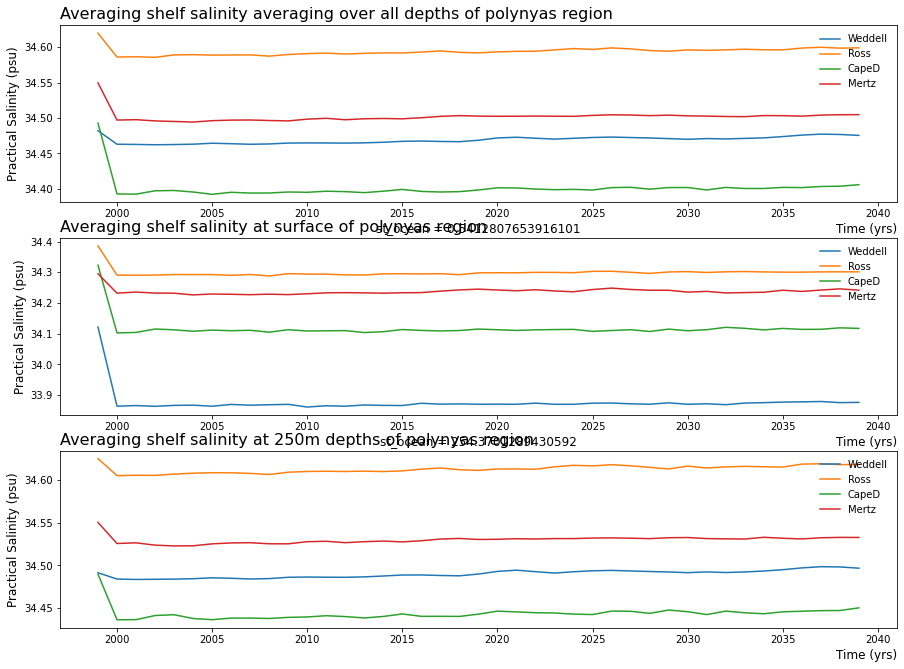

In [9]:
fig = plt.figure(figsize=(15, 15))

#Plotting mean shelf salinity at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Averaging shelf salinity averaging over all depths of polynyas region', fontsize=16, loc='left')
salt_st_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_st_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_st_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_st_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,2)
plt.title('Averaging shelf salinity at surface of polynyas region', fontsize=16, loc='left')
salt_surface_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_surface_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_surface_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_surface_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,3)
plt.title('Averaging shelf salinity at 250m depths of polynyas region', fontsize=16, loc='left')
salt_250m_shelf_Weddell.mean(("xt_ocean","yt_ocean")).plot(label='Weddell')
salt_250m_shelf_Ross.mean(("xt_ocean","yt_ocean")).plot(label='Ross')
salt_250m_shelf_CapeD.mean(("xt_ocean","yt_ocean")).plot(label='CapeD')
salt_250m_shelf_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)